# Estudo do Pacote ASTSA usando Sentinel-1

## Importação

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import eetools, saveModule
from osgeo import gdal

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [3]:
coordenadas = "-48.534679,-22.508117,-48.50481,-22.538879"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2020-01-01,2020-12-31"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])

latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

## Coleta



In [4]:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)

In [5]:
sentinel1

Filtrando apenas VV e VH no modo IW

In [6]:
v_emit = sentinel1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
                  .filter(ee.Filter.eq('instrumentMode', 'IW'))

Em quase todas as análises não tem imagens ascendentes

In [7]:
v_emit_asc = v_emit.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
v_emit_desc = v_emit.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

In [8]:
v_emit_desc

In [9]:
my_map = geemap.Map(center=(longitude_central, latitude_central), zoom=11)
my_map.addLayer(geom)

rgb = ee.Image.rgb(
    v_emit_desc.mean().select('VV'),
    v_emit_desc.mean().select('VH'),
    v_emit_desc.mean().select('VV').divide(v_emit_desc.mean().select('VH'))
).clip(geom)

my_map.addLayer(rgb, {'min': [-25,-25,0], 'max': [0,0,2]})

my_map

Map(center=[-22.523498, -48.5197445], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=H…

Função para adicionar amplitude à uma imagem como nova banda

In [10]:
def add_amplitude(image, VV = "VV", VH = "VH"):
    amplitude = image\
        .expression('(VV ** 2 + VH ** 2) ** (1 / 2)', {'VV':image.select(VV), 'VH':image.select(VH)})\
        .rename('amplitude')
    return image.addBands(amplitude)

In [11]:
image = v_emit_desc.median()

image_amp = add_amplitude(image)
image_amp

In [12]:
my_map2 = geemap.Map(center=(longitude_central, latitude_central), zoom=11)
my_map2.addLayer(geom)

rgb = ee.Image.rgb(
    image_amp.select('VV'),
    image_amp.select('VH'),
    image_amp.select('amplitude')
).clip(geom)

my_map2.addLayer(rgb, {'min': [-30,-30,0], 'max': [1,1,2]})
my_map2

Map(center=[-22.523498, -48.5197445], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=H…

In [13]:
def extrair_lonlat(imagem, geometria, bandas, scale=30):
    imagem = imagem.addBands(ee.Image.pixelLonLat())
    
    coordenadas = imagem.select(["longitude","latitude"] + bandas)\
        .reduceRegion(reducer=ee.Reducer.toList(),
                     geometry=geometria,
                     scale=scale,
                     bestEffort=True)
    
    coordenadas = coordenadas.getInfo()
    
    return pd.DataFrame.from_dict(coordenadas)

In [14]:
image = ee.Image(dummy_value).blend(v_emit_desc.map(add_amplitude).select('amplitude').toBands())
image_names = image.bandNames().getInfo()

df = extrair_lonlat(image, geom, image_names, scale=10)
df

,S1A_IW_GRDH_1SDV_20200104T083855_20200104T083920_030648_03832D_B27B_amplitude,S1A_IW_GRDH_1SDV_20200116T083854_20200116T083919_030823_03894C_C5F9_amplitude,S1A_IW_GRDH_1SDV_20200128T083854_20200128T083919_030998_038F78_F944_amplitude,S1A_IW_GRDH_1SDV_20200209T083854_20200209T083919_031173_03958F_9F83_amplitude,S1A_IW_GRDH_1SDV_20200221T083853_20200221T083918_031348_039B92_202E_amplitude,S1A_IW_GRDH_1SDV_20200304T083853_20200304T083918_031523_03A1A2_1555_amplitude,S1A_IW_GRDH_1SDV_20200316T083854_20200316T083919_031698_03A7B1_4449_amplitude,S1A_IW_GRDH_1SDV_20200328T083854_20200328T083919_031873_03ADDA_F477_amplitude,S1A_IW_GRDH_1SDV_20200409T083854_20200409T083919_032048_03B40A_F2B5_amplitude,S1A_IW_GRDH_1SDV_20200421T083855_20200421T083920_032223_03BA2D_B3D6_amplitude,S1A_IW_GRDH_1SDV_20200503T083855_20200503T083920_032398_03C056_F102_amplitude,S1A_IW_GRDH_1SDV_20200515T083856_20200515T083921_032573_03C5DA_8E40_amplitude,S1A_IW_GRDH_1SDV_20200527T083857_20200527T083922_032748_03CB29_3369_amplitude,S1A_IW_GRDH_1SDV_20200608T083857_20200608T083922_032923_03D051_2713_amplitude,S1A_IW_GRDH_1SDV_20200620T083858_20200620T083923_033098_03D59D_873E_amplitude,S1A_IW_GRDH_1SDV_20200702T083858_20200702T083923_033273_03DAEA_5A4C_amplitude,S1A_IW_GRDH_1SDV_20200714T083859_20200714T083924_033448_03E041_3A07_amplitude,S1A_IW_GRDH_1SDV_20200726T083900_20200726T083925_033623_03E5A1_DEB5_amplitude,S1A_IW_GRDH_1SDV_20200807T083901_20200807T083926_033798_03EB1F_F571_amplitude,S1A_IW_GRDH_1SDV_20200819T083901_20200819T083926_033973_03F144_11D1_amplitude,S1A_IW_GRDH_1SDV_20200831T083902_20200831T083927_034148_03F76D_8BE7_amplitude,S1A_IW_GRDH_1SDV_20200912T083903_20200912T083928_034323_03FD8E_4620_amplitude,S1A_IW_GRDH_1SDV_20200924T083903_20200924T083928_034498_0403BB_84CC_amplitude,S1A_IW_GRDH_1SDV_20201006T083903_20201006T083928_034673_0409E6_53DC_amplitude,S1A_IW_GRDH_1SDV_20201018T083903_20201018T083928_034848_04100A_74ED_amplitude,S1A_IW_GRDH_1SDV_20201030T083903_20201030T083928_035023_0415F4_73C5_amplitude,S1A_IW_GRDH_1SDV_20201111T083903_20201111T083928_035198_041C17_DD4C_amplitude,S1A_IW_GRDH_1SDV_20201123T083903_20201123T083928_035373_042222_26AF_amplitude,S1A_IW_GRDH_1SDV_20201205T083902_20201205T083927_035548_042828_DC7D_amplitude,S1A_IW_GRDH_1SDV_20201217T083902_20201217T083927_035723_042E31_4146_amplitude,S1A_IW_GRDH_1SDV_20201229T083901_20201229T083926_035898_043452_2EF1_amplitude,latitude,longitude
0,23.232272,25.493012,19.934587,20.970548,19.236771,20.370094,20.719599,23.277746,21.495142,20.964351,26.379407,22.354607,26.697029,21.735630,28.150376,24.381920,23.055817,24.380901,21.985210,23.434643,22.503563,23.802071,21.542170,22.900823,19.508060,18.330667,34.917936,34.744899,22.176487,18.454678,17.249297,-22.538865,-48.534672
1,22.366302,24.957498,21.127323,22.211759,20.330051,19.174086,21.392979,24.661084,21.435993,20.964351,22.842292,23.003069,25.814457,22.392967,28.742022,24.381920,24.256154,25.208826,20.224798,20.709936,22.940957,23.163693,22.037381,20.761715,19.508060,21.658065,38.496882,30.680289,21.323504,18.454678,18.878406,-22.538865,-48.534582
2,18.292136,22.778078,19.907908,23.559715,21.095674,19.788980,23.070025,25.695971,21.847929,20.231856,21.039000,25.266660,27.378982,22.465283,28.738127,26.074378,25.425421,25.283263,20.415215,20.573743,21.083499,20.623563,21.264223,21.234917,21.150355,21.658065,34.480091,28.558505,22.203894,23.322833,22.167860,-22.538865,-48.534493
3,17.016154,20.985433,19.907908,19.372443,21.616600,19.186477,21.439051,26.307725,22.798432,21.218703,22.271028,26.714019,27.378982,24.633378,28.497116,24.464142,25.425421,26.242476,22.994818,21.484548,18.742414,20.937095,20.388349,21.614886,21.538920,25.109325,33.364275,26.917001,22.119502,24.594171,20.951874,-22.538865,-48.534403
4,17.937145,19.243176,18.431678,18.882323,23.044974,18.358678,19.776645,26.307725,22.822476,21.482583,23.631014,23.877983,28.193225,24.633378,26.654868,24.972893,26.905394,26.666304,22.994818,24.079130,21.167879,21.312055,20.0

## Exportando

In [15]:
from src import saveModule

In [16]:
export = df.iloc[:,[0,1,2,3,4,5,6,31,32]]
export_columns = list(export.drop(['latitude','longitude'], axis = 1).columns)
export_columns

['S1A_IW_GRDH_1SDV_20200104T083855_20200104T083920_030648_03832D_B27B_amplitude',
 'S1A_IW_GRDH_1SDV_20200116T083854_20200116T083919_030823_03894C_C5F9_amplitude',
 'S1A_IW_GRDH_1SDV_20200128T083854_20200128T083919_030998_038F78_F944_amplitude',
 'S1A_IW_GRDH_1SDV_20200209T083854_20200209T083919_031173_03958F_9F83_amplitude',
 'S1A_IW_GRDH_1SDV_20200221T083853_20200221T083918_031348_039B92_202E_amplitude',
 'S1A_IW_GRDH_1SDV_20200304T083853_20200304T083918_031523_03A1A2_1555_amplitude',
 'S1A_IW_GRDH_1SDV_20200316T083854_20200316T083919_031698_03A7B1_4449_amplitude']

In [17]:
saveModule.save_tiff_from_df(
    export,
    export_columns,
    99999,
    "assets/amplitude.tif",
    "EPSG:4326"   
)

True

In [18]:
from osgeo import gdal

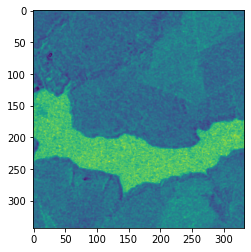

In [19]:
filepath = r"assets/amplitude.tif"
raster = gdal.Open(filepath)
array = raster.GetRasterBand(3).ReadAsArray()
plt.imshow(array)

In [20]:
raster.RasterCount

7

## Análise de Série Temporal

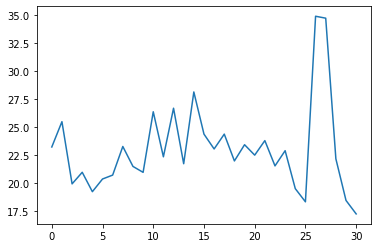

In [21]:
y = df.drop(['latitude','longitude'], axis=1).iloc[0,:]
plt.plot(range(0,len(y)), y)

In [22]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.robjects as robjects

rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

astsa = importr('astsa')
base = importr('base')
stats = importr('stats')

In [23]:
def get_specenv(x, *args): 
    scaled_time_series = stats.ts(robjects.FloatVector(list(x))).ravel()
    arrays = [i(scaled_time_series) for i in args]
    arrays.insert(0, scaled_time_series)
    arrays = np.stack(arrays, axis=1)

    spec_env = astsa.specenv(arrays, real=True, plot=False)
    num_coefs = spec_env[:,2:].shape[1]
    names_col = ['frequency', 'specenv'] + [f"coef{i}" for i in range(1, num_coefs+1)]

    
    return pd.DataFrame(spec_env, columns=names_col)

In [24]:
get_specenv(base.scale(y), np.abs, lambda k: k ** 2)

,frequency,specenv,coef1,coef2,coef3
0,0.03125,0.387381,0.542107,0.663556,-0.515571
1,0.06250,0.208085,-0.167347,-0.971629,0.167129
2,0.09375,0.160402,-0.098703,0.994455,-0.036298
3,0.12500,0.102156,-0.425713,-0.899212,0.100925
4,0.15625,0.212040,0.773615,-0.619251,0.134346
5,0.18750,0.253275,0.358526,-0.905227,0.228088
6,0.21875,0.103411,-0.072424,-0.906759,0.415382
7,0.25000,0.253274,-0.009096,-0.953243,0.302067
8,0.28125,0.064821,0.397523,0.708622,-0.582950
9,0.31250,0.076990,-0.304098,-0.923711,0.232988


In [25]:
nrow = 100

coords = df.head(nrow).loc[:,['latitude','longitude']]
df_specenv = df.head(nrow).drop(['latitude', 'longitude'], axis=1)
df_specenv['specenv'] = df_specenv.apply(lambda x: get_specenv(base.scale(x), np.abs, lambda x: x ** 2), axis = 1)
df_specenv = df_specenv.join(coords)

df_specenv.loc[0,'specenv']

,frequency,specenv,coef1,coef2,coef3
0,0.03125,0.387381,0.542107,0.663556,-0.515571
1,0.06250,0.208085,-0.167347,-0.971629,0.167129
2,0.09375,0.160402,-0.098703,0.994455,-0.036298
3,0.12500,0.102156,-0.425713,-0.899212,0.100925
4,0.15625,0.212040,0.773615,-0.619251,0.134346
5,0.18750,0.253275,0.358526,-0.905227,0.228088
6,0.21875,0.103411,-0.072424,-0.906759,0.415382
7,0.25000,0.253274,-0.009096,-0.953243,0.302067
8,0.28125,0.064821,0.397523,0.708622,-0.582950
9,0.31250,0.076990,-0.304098,-0.923711,0.232988


In [26]:
nrow = 60000

coords = df.head(nrow).loc[:, ['latitude','longitude']]
df_specenv = df.head(nrow).drop(['latitude','longitude'], axis=1)

series = df_specenv.apply(lambda x: get_specenv(base.scale(x), np.abs, lambda y: y**2).loc[:, 'specenv'], axis=1)
specenv_image = series.join(coords)

specenv_image

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,latitude,longitude
0,0.387381,0.208085,0.160402,0.102156,0.212040,0.253275,0.103411,0.253274,0.064821,0.076990,0.056805,0.072029,0.095982,0.183881,0.138005,0.103032,-22.538865,-48.534672
1,0.216062,0.123695,0.292971,0.078323,0.275103,0.261201,0.134362,0.088112,0.160608,0.141376,0.063650,0.162103,0.150151,0.058812,0.149263,0.076756,-22.538865,-48.534582
2,0.290023,0.238537,0.202146,0.097595,0.126320,0.111570,0.179230,0.104269,0.058191,0.117279,0.089673,0.126735,0.309282,0.316821,0.091666,0.195009,-22.538865,-48.534493
3,0.203458,0.350193,0.175638,0.068601,0.145730,0.119123,0.108306,0.059439,0.047848,0.101382,0.205251,0.236615,0.252129,0.187573,0.115924,0.234988,-22.538865,-48.534403
4,0.421240,0.220949,0.199073,0.105955,0.106441,0.220479,0.124589,0.064169,0.137538,0.062477,0.122988,0.165216,0.128015,0.206551,0.085306,0.123991,-22.538865,-48.534313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.055937,0.061813,0.124576,0.208989,0.204676,0.139204,0.280316,0.168246,0.253669,0.203718,0.097049,0.159793,0.198785,0.155825,0.157299,0.096537,-22.522696,-48.529732
59996,0.256558,0.193523,0.080336,0.156612,0.202274,0.174567,0.075267,0.077795,0.196154,0.155766,0.085221,0.194354,0.116357,0.100172,0.057983,0.195246,-22.522696,-48.529642
59997,0.432700,0.134416,0.141217,0.315638,0.039344,0.123741,0.210465,0.156526,0.055152,0.159706,0.141452,0.016193,0.050338,0.128743,0.115899,0.151673,-22.522696,-48.529552
59998,0.337898,0.149865,0.226007,0.163848,0.035918,0.103535,0.156706,0.164139,0.233888,0.314950,0.053365,0.118831,0.190182,0.080797,0.166973,0.135403,-22.522696,-48.529462


In [27]:
specenv_image_columns = list(specenv_image.drop(['latitude','longitude'], axis = 1).columns)
specenv_image_columns

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [28]:
saveModule.save_tiff_from_df(
    specenv_image,
    specenv_image_columns,
    99999,
    "assets/specenv.tif",
    "EPSG:4326"   
)

True

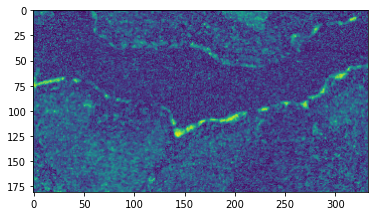

In [29]:
filepath = r"assets/specenv.tif"
raster = gdal.Open(filepath)
array = raster.GetRasterBand(1).ReadAsArray()
plt.imshow(array)

In [30]:
nrow = 60000

coords = df.head(nrow).loc[:, ['latitude','longitude']]
df_coef1 = df.head(nrow).drop(['latitude','longitude'], axis=1)

series = df_coef1.apply(lambda x: get_specenv(base.scale(x), np.abs, lambda y: y**2).loc[:, 'coef1'], axis=1)
coef1_image = series.join(coords)

coef1_image

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,latitude,longitude
0,0.542107,-0.167347,-0.098703,-0.425713,0.773615,0.358526,-0.072424,-0.009096,0.397523,-0.304098,-0.179833,-0.165203,-0.185952,0.450724,-0.291442,-0.073711,-22.538865,-48.534672
1,0.842443,0.485348,-0.084533,0.249536,0.962070,0.355801,0.182780,-0.537358,0.373943,-0.189966,-0.372154,-0.389520,-0.177154,-0.016837,-0.375297,0.870797,-22.538865,-48.534582
2,-0.220892,0.979787,-0.910405,0.413933,0.032249,-0.235743,0.441036,0.453614,0.316382,-0.088975,0.201520,0.869924,-0.012944,0.088374,0.905220,0.621541,-22.538865,-48.534493
3,0.443532,0.898503,0.481230,-0.002740,-0.014752,-0.529331,0.353875,0.183430,0.117346,-0.128972,0.240338,-0.032296,0.000580,0.003286,0.604985,-0.276220,-22.538865,-48.534403
4,0.556957,0.872818,-0.329690,0.031560,-0.245543,0.047037,0.815752,-0.422694,0.003335,0.666402,0.476057,-0.052478,-0.045080,0.003524,0.775463,0.363988,-22.538865,-48.534313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.167941,0.074137,0.451434,0.275658,0.982213,0.453732,0.034694,-0.009865,0.179150,0.022386,0.015150,0.089812,0.128684,0.280511,0.152345,0.192034,-22.522696,-48.529732
59996,0.148232,0.630873,0.443043,0.240791,0.433252,-0.099820,0.120819,0.022464,0.052811,0.788387,0.054958,-0.211514,0.507028,-0.053547,-0.247398,0.365078,-22.522696,-48.529642
59997,0.191303,0.926134,-0.194735,-0.043968,0.583051,-0.029068,-0.278342,0.381717,-0.172025,0.297202,-0.144612,0.902426,-0.021565,0.142148,0.406923,0.615450,-22.522696,-48.529552
59998,0.436671,0.070372,-0.185083,-0.054196,-0.192524,-0.075589,-0.245191,-0.440376,-0.176781,0.586042,-0.597806,-0.213614,-0.021623,0.178241,0.317662,0.662534,-22.522696,-48.529462


In [31]:
coef1_image_columns = list(coef1_image.drop(['latitude','longitude'], axis = 1).columns)
coef1_image_columns

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [32]:
saveModule.save_tiff_from_df(
    coef1_image,
    coef1_image_columns,
    99999,
    "assets/coef1.tif",
    "EPSG:4326"   
)

True

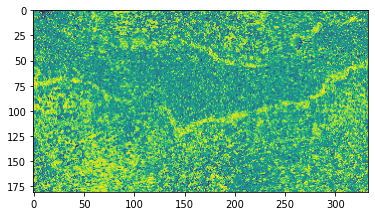

In [61]:
filepath = r"assets/coef1.tif"
raster = gdal.Open(filepath)
array = raster.GetRasterBand(1).ReadAsArray()
plt.imshow(array)

In [34]:
nrow = 60000

coords = df.head(nrow).loc[:, ['latitude','longitude']]
df_coef2 = df.head(nrow).drop(['latitude','longitude'], axis=1)

series = df_coef2.apply(lambda x: get_specenv(base.scale(x), np.abs, lambda y: y**2).loc[:, 'coef2'], axis=1)
coef2_image = series.join(coords)

coef2_image_columns = list(coef2_image.drop(['latitude','longitude'], axis = 1).columns)

saveModule.save_tiff_from_df(
    coef2_image,
    coef2_image_columns,
    99999,
    "assets/coef2.tif",
    "EPSG:4326"   
)

True

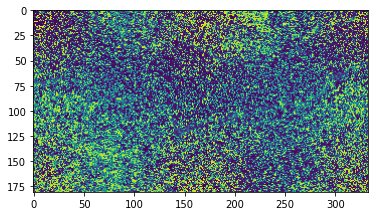

In [59]:
filepath = r"assets/coef2.tif"
raster = gdal.Open(filepath)
array = raster.GetRasterBand(1).ReadAsArray()
plt.imshow(array)

In [41]:
nrow = 60000

coords = df.head(nrow).loc[:, ['latitude','longitude']]
df_coef3 = df.head(nrow).drop(['latitude','longitude'], axis=1)

series = df_coef3.apply(lambda x: get_specenv(base.scale(x), np.abs, lambda y: y**2).loc[:, 'coef3'], axis=1)
coef3_image = series.join(coords)

coef3_image_columns = list(coef3_image.drop(['latitude','longitude'], axis = 1).columns)

saveModule.save_tiff_from_df(
    coef3_image,
    coef3_image_columns,
    99999,
    "assets/coef3.tif",
    "EPSG:4326"   
)

True

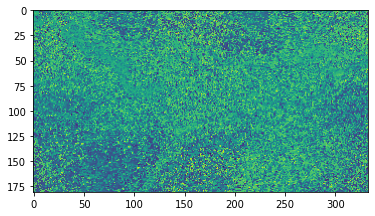

In [55]:
filepath = r"assets/coef3.tif"
raster = gdal.Open(filepath)
array = raster.GetRasterBand(1).ReadAsArray()
plt.imshow(array)

In [49]:
nrow = 60000

coords = df.head(nrow).loc[:, ['latitude','longitude']]
df_coef_freq = df.head(nrow).drop(['latitude','longitude'], axis=1)

series = df_coef_freq.apply(lambda x: get_specenv(base.scale(x), np.abs, lambda y: y**2).loc[:, 'frequency'], axis=1)
freq_image = series.join(coords)

freq_image_columns = list(freq_image.drop(['latitude','longitude'], axis = 1).columns)

saveModule.save_tiff_from_df(
    freq_image,
    freq_image_columns,
    99999,
    "assets/frequency.tif",
    "EPSG:4326"   
)

True

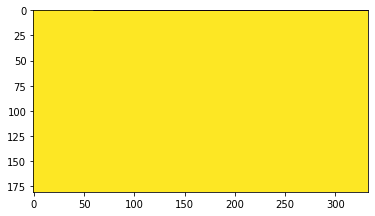

In [52]:
filepath = r"assets/frequency.tif"
raster = gdal.Open(filepath)
array = raster.GetRasterBand(3).ReadAsArray()
plt.imshow(array)